# Reset and Readout of Qubit

### Import

In [1]:
#!pip install c3-toolset
#!pip install matplotlib
#!pip install plotly
#!pip install numpy
#!pip install --upgrade nbformat

In [1]:
import os
from re import I
import numpy as np
import copy
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from c3.c3objs import Quantity as Qty
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.model import Model as Mdl
from c3.generator.generator import Generator as Gnr

# Building blocks
import c3.generator.devices as devices
import c3.signal.gates as gates
import c3.libraries.chip as chip
import c3.signal.pulse as pulse
import c3.libraries.tasks as tasks

# Libs and helpers
import c3.libraries.algorithms as algorithms
import c3.libraries.hamiltonians as hamiltonians
import c3.libraries.fidelities as fidelities
import c3.libraries.envelopes as envelopes
import c3.utils.qt_utils as qt_utils
import c3.utils.tf_utils as tf_utils
from c3.optimizers.optimalcontrol import OptimalControl

import plotly.graph_objects as go
from plotting import *
from utilities_functions import *

import scipy as sp

2022-02-15 11:57:00.192998: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-15 11:57:00.193020: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Define Qubit and resonator

Qubit

In [2]:
qubit_levels = 3
qubit_frequency = 7.86e9
qubit_anharm = -264e6
qubit_t1 = 27e-6
qubit_t2star = 39e-6
qubit_temp = 50e-3

qubit = chip.Qubit(
    name="Q",
    desc="Qubit",
    freq=Qty(value=qubit_frequency,min_val=1e9 ,max_val=8e9 ,unit='Hz 2pi'),
    anhar=Qty(value=qubit_anharm,min_val=-380e6 ,max_val=-120e6 ,unit='Hz 2pi'),
    hilbert_dim=qubit_levels,
    t1=Qty(value=qubit_t1,min_val=1e-6,max_val=90e-6,unit='s'),
    t2star=Qty(value=qubit_t2star,min_val=10e-6,max_val=90e-3,unit='s'),
    temp=Qty(value=qubit_temp,min_val=0.0,max_val=0.12,unit='K')
)

2022-02-15 11:57:03.852185: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-15 11:57:03.852246: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-15 11:57:03.852270: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ashutosh-X1): /proc/driver/nvidia/version does not exist
2022-02-15 11:57:03.852908: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Resonator

In [3]:
resonator_levels = 10
resonator_frequency = 6.02e9
resonator_t1 = 27e-6
resonator_t2star = 39e-6
resonator_temp = 50e-3

parameters_resonator = {
    "freq": Qty(value=resonator_frequency,min_val=0e9 ,max_val=8e9 ,unit='Hz 2pi'),
    "t1": Qty(value=resonator_t1,min_val=1e-6,max_val=90e-6,unit='s'),
    "t2star": Qty(value=resonator_t2star,min_val=10e-6,max_val=90e-3,unit='s'),
    "temp": Qty(value=resonator_temp,min_val=0.0,max_val=0.12,unit='K')
}

resonator = chip.ReadoutResonator(
    name="R",
    desc="Resonator",
    hilbert_dim=resonator_levels,
    params=parameters_resonator
)

Coupling

In [4]:
coupling_strength = 130e6
qr_coupling = chip.Coupling(
    name="Q-R",
    desc="coupling",
    comment="Coupling qubit and resonator",
    connected=["Q", "R"],
    strength=Qty(
        value=coupling_strength,
        min_val=-1 * 1e3 ,
        max_val=200e6 ,
        unit='Hz 2pi'
    ),
    hamiltonian_func=hamiltonians.jaynes_cummings
)

Drives

In [5]:
drive_qubit = chip.Drive(
    name="dQ",
    desc="Drive 1",
    comment="Drive line on qubit",
    connected=["Q"],
    hamiltonian_func=hamiltonians.x_drive
)

drives = [drive_qubit]

Model

In [6]:
model = Mdl(
    [qubit, resonator], # Individual, self-contained components
    [drive_qubit, qr_coupling]  # Interactions between components
)
model.set_lindbladian(False)
model.set_dressed(False)

sim_res = 100e9
awg_res = 2e9
v2hz = 1e9

generator = Gnr(
        devices={
            "LO": devices.LO(name='lo', resolution=sim_res, outputs=1),
            "AWG": devices.AWG(name='awg', resolution=awg_res, outputs=1),
            "DigitalToAnalog": devices.DigitalToAnalog(
                name="dac",
                resolution=sim_res,
                inputs=1,
                outputs=1
            ),
            "Response": devices.Response(
                name='resp',
                rise_time=Qty(
                    value=0.3e-9,
                    min_val=0.05e-9,
                    max_val=0.6e-9,
                    unit='s'
                ),
                resolution=sim_res,
                inputs=1,
                outputs=1
            ),
            "Mixer": devices.Mixer(name='mixer', inputs=2, outputs=1),
            "QuadraturesToValues": devices.QuadraturesToValues(name="quad_to_val", inputs=1, outputs=1),
            "VoltsToHertz": devices.VoltsToHertz(
                name='v_to_hz',
                V_to_Hz=Qty(
                    value=1e9,
                    min_val=0.9e9,
                    max_val=1.1e9,
                    unit='Hz/V'
                ),
                inputs=1,
                outputs=1
            )
        },
        chains= {
            "dQ":["AWG", "DigitalToAnalog", "Response", "QuadraturesToValues", "VoltsToHertz"],
            "R": ["AWG", "DigitalToAnalog", "Response", "QuadraturesToValues", "VoltsToHertz"]
        }
    )

generator.devices["AWG"].enable_drag_2()

In [7]:
model.get_qubit_freqs()

[7869139386.74453, 6010860613.25547]

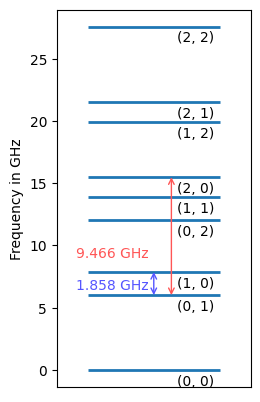

In [8]:
def plotEnergyLevelsDressed(model):
    model.set_dressed(True)
    H = np.real(model.get_Hamiltonian().numpy())/(2*np.pi*1e9)
    states_to_plot = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2), (2,0), (2,1), (2,2)]
    state_indices = model.get_state_indeces(states_to_plot)
    energies = [H[i,i] for i in state_indices]
    states_diff = [(1,0), (0,1), (2,0)]
    states_diff_index = model.get_state_indeces(states_diff)
    states_diff_energy = [H[i,i] for i in states_diff_index]
    energy_diff = np.abs(np.ediff1d(states_diff_energy))

    x = [1]*len(states_to_plot)
    plt.figure(figsize=(2.5,5), dpi=100)
    plt.scatter(x, energies, s=9000, marker="_", linewidth=2, zorder=3)
    
    cmap = plt.cm.get_cmap("seismic", 4)

    for xi,yi,tx in zip(x,energies,states_to_plot):
        plt.annotate(tx, xy=(xi,yi), xytext=(30,-3), size=10,
                    ha="center",va='top', textcoords="offset points")
    for i in range(1,len(states_diff)):
        plt.annotate(text='', xy=(1+(i-1)*0.01,states_diff_energy[i-1]), 
                    xytext=(1+(i-1)*0.01,states_diff_energy[i]), 
                    arrowprops=dict(arrowstyle='<->', shrinkA=0, shrinkB=0, color=cmap(i)))
        plt.annotate(f"{round(energy_diff[i-1],3)} GHz", xy=(1,states_diff_energy[i-1]), xytext=(-30,-5 + (i-1)*40), size=10,
                    ha="center",va='top', textcoords="offset points", color=cmap(i))

    plt.xticks([])
    plt.ylabel("Frequency in GHz")
    plt.savefig("Energy Levels.png")
    plt.show()
    model.set_dressed(False)
    model.update_model()

plotEnergyLevelsDressed(model)

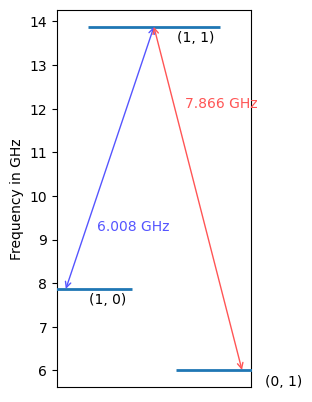

In [32]:
def plotLambdaSystem(model):
    model.set_dressed(True)
    H = np.real(model.get_Hamiltonian().numpy())/(2*np.pi*1e9)
    states_to_plot = [(1,0), (1,1), (0,1)]
    state_indices = model.get_state_indeces(states_to_plot)
    energies = [H[i,i] for i in state_indices]
    states_diff = [(1,0), (1,1), (0,1)]
    states_diff_index = model.get_state_indeces(states_diff)
    states_diff_energy = [H[i,i] for i in states_diff_index]
    energy_diff = np.abs(np.ediff1d(states_diff_energy))

    x = [1,2,3]
    plt.figure(figsize=(2.5,5), dpi=100)
    plt.scatter(x, energies, s=9000, marker="_", linewidth=2, zorder=3)
    
    cmap = plt.cm.get_cmap("seismic", 4)

    for xi,yi,tx in zip(x,energies,states_to_plot):
        plt.annotate(tx, xy=(xi,yi), xytext=(30,-3), size=10,
                    ha="center",va='top', textcoords="offset points")
    for i in range(1,len(states_diff)):
        plt.annotate(text='', xy=(i,states_diff_energy[i-1]), 
                    xytext=(i+1,states_diff_energy[i]), 
                    arrowprops=dict(arrowstyle='<->', shrinkA=0, shrinkB=0, color=cmap(i)))
        plt.annotate(f"{round(energy_diff[i-1],3)} GHz", xy=(i+1,states_diff_energy[i-1]), xytext=(-15, 50 - (i-1)*100), size=10,
                    ha="center",va='top', textcoords="offset points", color=cmap(i))

    plt.xticks([])
    plt.ylabel("Frequency in GHz")
    plt.savefig("Energy Levels.png")
    plt.show()
    model.set_dressed(False)
    model.update_model()

plotLambdaSystem(model)

### Qubit X gate

In [ ]:
t_X_gate = 15e-9
sideband = 50e6
gauss_params = {
    "amp": Qty(value=0.5,min_val=0.2,max_val=0.6,unit="V"),
    "t_final": Qty(value=t_X_gate,min_val=0.5 * t_X_gate,max_val=1.5 * t_X_gate,unit="s"),
    "sigma": Qty(value=t_X_gate / 4,min_val=t_X_gate / 8,max_val=t_X_gate / 2,unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit="")
}

gauss_pulse = pulse.Envelope(
    name="gauss",
    desc="Gaussian comp for single qubit gates",
    params=gauss_params,
    shape=envelopes.gaussian_nonorm
)

nodrive_pulse = pulse.Envelope(
    name="no_drive",
    params={
        "t_final": Qty(
            value=t_X_gate,
            min_val=0.5 * t_X_gate,
            max_val=1.5 * t_X_gate,
            unit="s"
        )
    },
    shape=envelopes.no_drive
)

## Create carriers
qubit_freqs = model.get_qubit_freqs()
carriers = createCarriers(qubit_freqs, sideband)

qubit_pulse = copy.deepcopy(gauss_pulse)
resonator_pulse = copy.deepcopy(nodrive_pulse)
X_gate = gates.Instruction(
    name="x", targets=[0], t_start=0.0, t_end=t_X_gate, channels=["dQ", "dR"]
)
X_gate.add_component(qubit_pulse, "dQ")
X_gate.add_component(copy.deepcopy(carriers[0]), "dQ")
X_gate.add_component(resonator_pulse, "dR")
X_gate.add_component(copy.deepcopy(carriers[1]), "dR")

single_q_gates = [X_gate]

In [ ]:
parameter_map = PMap(instructions=single_q_gates, model=model, generator=generator)
exp = Exp(pmap=parameter_map)
exp.set_opt_gates(['x[0]'])
unitaries = exp.compute_propagators()

psi_init = [[0] * model.tot_dim]
psi_init[0][0] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = ['x[0]']
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)

Optimize the X gate

In [ ]:
parameter_map.set_opt_map([
    [("x[0]", "dQ", "gauss", "amp")],
    [("x[0]", "dQ", "gauss", "freq_offset")],
    [("x[0]", "dQ", "gauss", "xy_angle")],
    [("x[0]", "dQ", "gauss", "delta")],
    [("x[0]", "dR", "carrier", "framechange")]
])

parameter_map.print_parameters()

opt = OptimalControl(
    dir_path="./output/",
    fid_func=fidelities.average_infid_set,
    fid_subspace=["Q", "R"],
    pmap=parameter_map,
    algorithm=algorithms.lbfgs,
    options={"maxfun": 150},
    run_name="better_x"
)
exp.set_opt_gates(["x[0]"])
opt.set_exp(exp)

opt.optimize_controls()
opt.current_best_goal

plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=Fasle)


### Readout of Resonator

In [ ]:
def calculateState(
    exp: Experiment,
    psi_init: tf.Tensor,
    sequence: List[str]
):

    """
    Calculates the state of system with time.

    Parameters
    ----------
    exp: Experiment,
        The experiment containing the model and propagators
    psi_init: tf.Tensor,
        Initial state vector
    sequence: List[str]
        List of gate names that will be applied to the state

    Returns
    -------
    psi_list: List[tf.Tensor]
        List of states
    """

    model = exp.pmap.model
    dUs = exp.partial_propagators
    psi_t = psi_init.numpy()
    psi_list = [psi_t]
    for gate in sequence:
        for du in dUs[gate]:
            psi_t = np.matmul(du, psi_t)
            psi_list.append(psi_t)

    return psi_list

def calculateExpectationValue(states, Op):
    expect_val = []
    for i in states:
        expect_val.append(np.matmul(np.matmul(i.T.conj(), Op.numpy()),i)[0,0])
    return expect_val

def plotNumberOperator(
    exp: Experiment, 
    init_state: tf.Tensor,
    sequence: List[str]
):
    model = exp.pmap.model
    psi_list = calculateState(exp, init_state, sequence)

    aR = tf.convert_to_tensor(model.ann_opers[1], dtype=tf.complex128)
    aR_dag = tf.transpose(aR, conjugate=True)
    NR = tf.matmul(aR_dag,aR)
    expect_val_R = calculateExpectationValue(psi_list, NR)

    aQ = tf.convert_to_tensor(model.ann_opers[0], dtype=tf.complex128)
    aQ_dag = tf.transpose(aQ, conjugate=True)
    NQ = tf.matmul(aQ_dag, aQ)
    expect_val_Q = calculateExpectationValue(psi_list, NQ)


    ts = exp.ts

    fig = go.Figure()
    fig.add_trace(go.Scatter(x = ts, y = np.real(expect_val_R), mode = "lines", name="Resonator"))
    fig.add_trace(go.Scatter(x = ts, y = np.real(expect_val_Q), mode = "lines", name="Qubit"))
    fig.show()

def frameOfDrive(exp, psi_list, freq):
    model = exp.pmap.model
    aR = tf.convert_to_tensor(model.ann_opers[1], dtype = tf.complex128)
    aQ = tf.convert_to_tensor(model.ann_opers[0], dtype = tf.complex128)

    n = len(psi_list)

    aR_dag = tf.transpose(aR, conjugate=True)
    NR = tf.matmul(aR_dag,aR)

    aQ_dag = tf.transpose(aQ, conjugate=True)
    NQ = tf.matmul(aQ_dag, aQ)

    dt = (exp.ts[1] - exp.ts[0]).numpy()
    ts = np.linspace(0.0, dt*n, n)

    I = tf.eye(len(aR), dtype=tf.complex128)

    psi_rotated = []
    
    for i in range(n):
        U = tf.linalg.expm(1j*2*np.pi*freq*(NR + NQ)*ts[i]).numpy()
        psi_rotated.append(np.matmul(U, psi_list[i]))

    return psi_rotated

def ptraceTwoSubsystems(exp, state, trace_index):
    dims = exp.pmap.model.dims
    dims_remaining = [i for i in dims if i != dims[trace_index]]
    print(dims_remaining)
    state_dag = tf.transpose(state, conjugate=True)
    dm = tf.matmul(state, state_dag)
    dm_ptrace = np.zeros((np.prod(dims_remaining),np.prod(dims_remaining)), dtype=np.complex128)
    
    for i in range(np.prod(dims_remaining)):
        for j in range(np.prod(dims_remaining)):
            dm_ptrace[i,j] = np.sum([dm[i+x*dims_remaining[0],j+x*dims_remaining[0]] for x in range(dims[trace_index])])

    return dm_ptrace


def plotIQ(
        exp: Experiment, 
        sequence: List[str], 
        annihilation_operator: tf.Tensor
):
    
    """
    Calculate and plot the I-Q values for resonator 

    Parameters
    ----------
    exp: Experiment,
 
    sequence: List[str], 

    annihilation_operator: tf.Tensor


    Returns
    -------
        
    """
    model = exp.pmap.model
    annihilation_operator = tf.convert_to_tensor(annihilation_operator, dtype=tf.complex128)
    
    state_index = exp.pmap.model.get_state_index((0,0))
    psi_init_0 = [[0] * model.tot_dim]
    psi_init_0[0][state_index] = 1
    init_state_0 = tf.transpose(tf.constant(psi_init_0, tf.complex128))
    
    psi_list = calculateState(exp, init_state_0, sequence)
    psi_list_0 =  frameOfDrive(exp, psi_list, resonator_frequency)
    expect_val_0 = calculateExpectationValue(psi_list_0, annihilation_operator)
    Q0 = np.real(expect_val_0)
    I0 = np.imag(expect_val_0)
    

    state_index = exp.pmap.model.get_state_index((1,0))
    psi_init_1 = [[0] * model.tot_dim]
    psi_init_1[0][state_index] = 1
    init_state_1 = tf.transpose(tf.constant(psi_init_1, tf.complex128))
    
    psi_list = calculateState(exp, init_state_1, sequence)
    psi_list_1 =  frameOfDrive(exp, psi_list, resonator_frequency)
    expect_val_1 = calculateExpectationValue(psi_list_1, annihilation_operator)
    Q1 = np.real(expect_val_1)
    I1 = np.imag(expect_val_1)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x = Q0, y = I0, mode = "lines", name="Ground state"))
    fig.add_trace(go.Scatter(x = Q1, y = I1, mode = "lines", name ="Excited state"))
    fig.show()


Define readout pulse for the resonator

In [ ]:
qubit_freqs = model.get_qubit_freqs()
sideband = 50e6
carriers = createCarriers([0.0, 0.0], sideband)

t_readout = 60e-9
sideband = 50e6
readout_params = {
    "amp": Qty(value=2*np.pi*0.005,min_val=0.0,max_val=100.0,unit="V"),
    "t_final": Qty(value=t_readout,min_val=0.5 * t_readout,max_val=1.5 * t_readout,unit="s"),
    "sigma": Qty(value=t_readout / 4,min_val=t_readout / 8,max_val=t_readout / 2,unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit="")
}

readout_pulse = pulse.Envelope(
    name="readout",
    desc="Gaussian pulse for readout",
    params=readout_params,
    shape=envelopes.gaussian_nonorm
)

nodrive_pulse = pulse.Envelope(
    name="no_drive",
    params={
        "t_final": Qty(
            value=t_readout,
            min_val=0.5 * t_readout,
            max_val=1.5 * t_readout,
            unit="s"
        )
    },
    shape=envelopes.no_drive
)

qubit_pulse = copy.deepcopy(nodrive_pulse)
resonator_pulse = copy.deepcopy(readout_pulse)
Readout_gate = gates.Instruction(
    name="Readout", targets=[1], t_start=0.0, t_end=t_readout, channels=["R", "dQ"]
)
Readout_gate.add_component(qubit_pulse, "dQ")
Readout_gate.add_component(copy.deepcopy(carriers[0]), "dQ")
Readout_gate.add_component(resonator_pulse, "R")
Readout_gate.add_component(copy.deepcopy(carriers[1]), "R")

readout_gates = [Readout_gate]

In [ ]:
parameter_map = PMap(instructions=readout_gates, model=model, generator=generator)
exp = Exp(pmap=parameter_map)

model.use_FR = False
exp.use_control_fields = False

exp.set_opt_gates(['Readout[1]'])
unitaries = exp.compute_propagators()

psi_init = [[0] * model.tot_dim]
psi_init[0][0] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = ['Readout[1]']
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)


In [ ]:
sig = np.loadtxt("signal.txt", dtype=np.complex128)
plt.plot(exp.ts, np.imag(sig)[1:])

In [ ]:
plotNumberOperator(exp, init_state, sequence)

In [ ]:
plotIQ(exp, sequence, model.ann_opers[1])

### Qubit Resonator SWAP

Add a resonator drive

In [9]:
drive_resonator = chip.Drive(
    name="dR",
    desc="Drive 2",
    comment="Drive line on resonator",
    connected=["R"],
    hamiltonian_func=hamiltonians.x_drive
)

model = Mdl(
    [qubit, resonator], # Individual, self-contained components
    [drive_qubit, drive_resonator, qr_coupling]  # Interactions between components
)
model.set_lindbladian(False)
model.set_dressed(False)

generator = Gnr(
        devices={
            "LO": devices.LO(name='lo', resolution=sim_res, outputs=1),
            "AWG": devices.AWG(name='awg', resolution=awg_res, outputs=1),
            "DigitalToAnalog": devices.DigitalToAnalog(
                name="dac",
                resolution=sim_res,
                inputs=1,
                outputs=1
            ),
            "Response": devices.Response(
                name='resp',
                rise_time=Qty(
                    value=0.3e-9,
                    min_val=0.05e-9,
                    max_val=0.6e-9,
                    unit='s'
                ),
                resolution=sim_res,
                inputs=1,
                outputs=1
            ),
            "Mixer": devices.Mixer(name='mixer', inputs=2, outputs=1),
            "VoltsToHertz": devices.VoltsToHertz(
                name='v_to_hz',
                V_to_Hz=Qty(
                    value=1e9,
                    min_val=0.9e9,
                    max_val=1.1e9,
                    unit='Hz/V'
                ),
                inputs=1,
                outputs=1
            )
        },
        chains= {
            "dQ": ["LO", "AWG", "DigitalToAnalog", "Response", "Mixer", "VoltsToHertz"],
            "dR": ["LO", "AWG", "DigitalToAnalog", "Response", "Mixer", "VoltsToHertz"]
        }
    )

generator.devices["AWG"].enable_drag_2()


Define SWAP gate for qubit and resonator by using Rabi oscillations

In [1]:
t_swap_gate = 200e-9
sideband = 50e6

swap_params = {
    "amp": Qty(value=1.0,min_val=0.2,max_val=1.0,unit="V"),
    "t_up": Qty(value=2.0e-9, min_val=0.1e-9, max_val=5.0e-9, unit="s"),
    "t_down": Qty(value=t_swap_gate-2.0e-9, min_val=t_swap_gate-5.0e-9, max_val=t_swap_gate-0.1e-9, unit="s"),
    "risefall": Qty(value=1.0e-9, min_val=0.1e-9, max_val=5.0e-9, unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit=""),
    "t_final": Qty(value=t_swap_gate,min_val=0.5*t_swap_gate,max_val=1.5*t_swap_gate,unit="s")
}

swap_pulse = pulse.Envelope(
    name="swap_pulse",
    desc="Flattop pluse for SWAP gate",
    params=swap_params,
    shape=envelopes.flattop
)

nodrive_pulse = pulse.Envelope(
    name="no_drive",
    params={
        "t_final": Qty(
            value=t_swap_gate,
            min_val=0.5 * t_swap_gate,
            max_val=1.5 * t_swap_gate,
            unit="s"
        )
    },
    shape=envelopes.no_drive
)


tlist = np.linspace(0,t_swap_gate, 1000)
#plotSignal(tlist, swap_pulse.shape(tlist, swap_pulse.params).numpy())

index = model.get_state_indeces([(1,0),(0,1)])
state_energies = [model.eigenframe[i].numpy() for i in index]
print(abs(state_energies[0] - state_energies[1])/(2*np.pi*1e9))

drive_freq = 9.5105e9
carrier_freq = [drive_freq, drive_freq]
carrier_parameters = {
            "Q":{"freq": Qty(value=carrier_freq[0], min_val=0.0, max_val=10e9, unit="Hz 2pi"),
            "framechange": Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad")},
            "R": {"freq": Qty(value=carrier_freq[1], min_val=0.0, max_val=10e9, unit="Hz 2pi"),
            "framechange": Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad")}
            }

carriers = [
    pulse.Carrier(name="carrier", desc="Frequency of the local oscillator", params=carrier_parameters["Q"]),
    pulse.Carrier(name="carrier", desc="Frequency of the local oscillator", params=carrier_parameters["R"])
]


qubit_pulse = copy.deepcopy(swap_pulse)
resonator_pulse = copy.deepcopy(swap_pulse)


ideal_gate = np.loadtxt("ideal_gate.csv", delimiter=",", dtype=np.complex128)

swap_gate = gates.Instruction(
    name="swap", targets=[0, 1], t_start=0.0, t_end=t_swap_gate, channels=["dQ", "dR"], 
    ideal=ideal_gate
)
swap_gate.add_component(qubit_pulse, "dQ")
swap_gate.add_component(copy.deepcopy(carriers[0]), "dQ")
swap_gate.add_component(resonator_pulse, "dR")
swap_gate.add_component(copy.deepcopy(carriers[1]), "dR")

gates_arr = [swap_gate]

NameError: name 'Qty' is not defined

### Create a PWC swap pulse

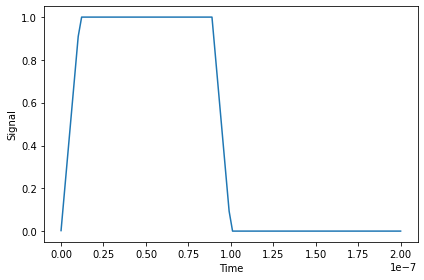

In [11]:
tlist = np.linspace(0,t_swap_gate, 10)
swap_gate_shape = swap_pulse.shape(tlist, swap_pulse.params)

pwc_params = {
    "t_bin_start": Qty(value=0.0, min_val=0.0, max_val=1e-9, unit="s"),
    "t_bin_end": Qty(value=100e-9, min_val=50e-9, max_val=200e-9, unit="s"),
    "inphase": Qty(value=swap_gate_shape, min_val=0.0, max_val=1.0, unit="") 
}

pwc_swap_pulse = pulse.Envelope(
    name="swap_pulse",
    desc="Flattop pluse for SWAP gate",
    params=pwc_params,
    shape=envelopes.pwc_shape
)
tlist = np.linspace(0,t_swap_gate, 100)
plotSignal(tlist, pwc_swap_pulse.shape(tlist, pwc_swap_pulse.params).numpy())


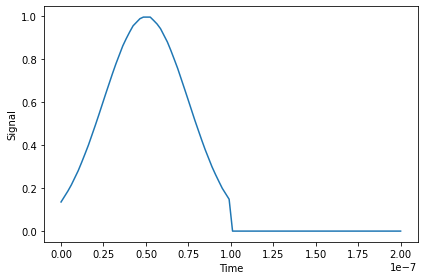

In [12]:
# Gaussian PWC pulse
swap_params = {
    "amp": Qty(value=1.0,min_val=0.2,max_val=1.0,unit="V"),
    "t_final": Qty(value=t_swap_gate,min_val=100e-9,max_val=300e-9,unit="s"),
    "sigma": Qty(value=t_swap_gate/4, min_val=t_swap_gate/8, max_val=t_swap_gate/2, unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit="")
}
swap_pulse = pulse.Envelope(
    name="swap_pulse",
    desc="Flattop pluse for SWAP gate",
    params=swap_params,
    shape=envelopes.gaussian_nonorm
)

tlist = np.linspace(0,t_swap_gate, 20)
swap_gate_shape = swap_pulse.shape(tlist, swap_pulse.params)

pwc_params = {
    "t_bin_start": Qty(value=0.0, min_val=0.0, max_val=1e-9, unit="s"),
    "t_bin_end": Qty(value=100e-9, min_val=50e-9, max_val=200e-9, unit="s"),
    "inphase": Qty(value=swap_gate_shape, min_val=0.0, max_val=1.0, unit="") 
}

pwc_swap_pulse = pulse.Envelope(
    name="swap_pulse_pwc",
    desc="Flattop pluse for SWAP gate",
    params=pwc_params,
    shape=envelopes.pwc_shape
)

tlist = np.linspace(0,t_swap_gate, 100)
plotSignal(tlist, pwc_swap_pulse.shape(tlist, pwc_swap_pulse.params).numpy())



In [13]:
print(swap_gate_shape)

tf.Tensor(
[0.13533528 0.20167293 0.28749857 0.39208051 0.51152434 0.63842347
 0.76225957 0.87065963 0.95136118 0.99447515 0.99447515 0.95136118
 0.87065963 0.76225957 0.63842347 0.51152434 0.39208051 0.28749857
 0.20167293 0.13533528], shape=(20,), dtype=float64)


In [14]:
model.get_state_indeces([(1,0)])

[10]

In [15]:
parameter_map = PMap(instructions=gates_arr, model=model, generator=generator)
exp = Exp(pmap=parameter_map)
exp.set_opt_gates(['swap[0, 1]'])
unitaries = exp.compute_propagators()
#plotComplexMatrix(unitaries['swap[0, 1]'].numpy())

2022-02-10 18:14:38.646045: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 288000000 exceeds 10% of free system memory.
2022-02-10 18:14:38.836440: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 288000000 exceeds 10% of free system memory.
2022-02-10 18:14:38.951369: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 288000000 exceeds 10% of free system memory.
2022-02-10 18:14:39.096161: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 288000000 exceeds 10% of free system memory.
2022-02-10 18:14:39.253798: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 288000000 exceeds 10% of free system memory.


In [ ]:
psi_init = [[0] * model.tot_dim]
psi_init[0][20] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = ['swap[0, 1]']
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)

In [ ]:
parameter_map.set_opt_map([
    [("swap[0, 1]", "dQ", "carrier", "freq")],
    [("swap[0, 1]", "dR", "carrier", "freq")]
])

parameter_map.print_parameters()

opt = OptimalControl(
    dir_path="./output/",
    fid_func=fidelities.average_infid_set_full_hilbert_space,
    fid_subspace=["Q", "R"],
    pmap=parameter_map,
    algorithm=algorithms.lbfgs,
    options={"maxfun": 150},
    run_name="better_swap"
)
exp.set_opt_gates(["swap[0, 1]"])
opt.set_exp(exp)

opt.optimize_controls()
opt.current_best_goal

In [ ]:
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)

### Rough code

Lets do a sweep over the frequencies of the drive and see if it we can see a reset at some point

In [ ]:
labels = list(map(str, model.state_labels))
x = np.array([[0]*10, [1]*10, [2]*10]).flatten()
y = model.eigenframe.numpy()
plt.scatter(x, y)

for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i], y[i]))

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y/(2*np.pi*1e9), mode="markers+text", text=labels, textposition="top center"))
fig.update_layout(height=500, width=500)

In [ ]:
from qutip import *
import numpy as np
Nq = 3
Nr = 10
Ideal_gate = np.array(tensor(qeye(Nq), qeye(Nr)) + tensor(basis(Nq,2),basis(Nr,0))*tensor(basis(Nq,0),basis(Nr,1)).dag() + tensor(basis(Nq,0),basis(Nr,1))*tensor(basis(Nq,2),basis(Nr,0)).dag() - tensor(basis(Nq,2),basis(Nr,0))*tensor(basis(Nq,2),basis(Nr,0)).dag() - tensor(basis(Nq,0),basis(Nr,1))*tensor(basis(Nq,0),basis(Nr,1)).dag()) 
print(Ideal_gate)
np.savetxt("ideal_gate.csv", Ideal_gate, delimiter=",")

In [ ]:
M = np.loadtxt("ideal_gate.csv", delimiter=",", dtype=np.complex128)
print(M)

In [16]:
S1 = 1e-3*np.array([222.709, 184.484, 385.353, 312.927, 385.534, 784.178, 910.896, 908.711, 817.750, 961.624, 926.969, 963.345, 832.831, 851.991, 763.276, 509.516, 28.116, 354.890, 234.149, 59.627])
S2 = 1e-3*np.array([53.001, 68.854, 358.599, 369.641, 765.301, 756.247, 706.647, 932.586, 914.490, 941.380, 714.821, 888.600, 955.149, 925.484, 519.482, 474.930, 225.622, 379.359, 126.467, 73.799]) 

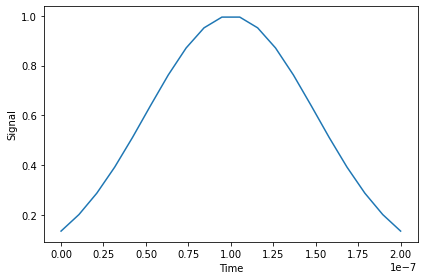

In [19]:
tlist = np.linspace(0,t_swap_gate, 20)
plotSignal(tlist,swap_gate_shape.numpy())

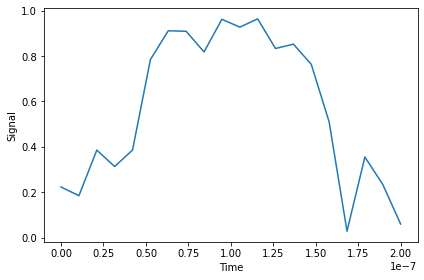

In [20]:
plotSignal(tlist, S1)

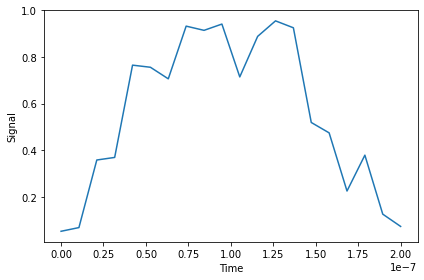

In [21]:
plotSignal(tlist, S2)